<a href="https://colab.research.google.com/github/da5nsy/ReplicatingKay2008/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pre-flight

In [1]:
# @title Load libraries 

import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import time

# Progress bar
# Source code: https://stackoverflow.com/a/46939639/6464224
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [2]:
# @title Load experimental data 

# Source code: https://github.com/NeuromatchAcademy/course-content/blob/9f1fd9aafb65feec583703973c9edf0535d8a62e/projects/load_kay_images.ipynb

fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

with np.load(fname) as dobj:
  dat = dict(**dobj)

### Generate gabors

In [3]:
# @title Define gabor functions

def gabor_fn(theta,lmbda,psi,gamma,x0=0,y0=0):
# % produce a gabor wavelet for the given sf,angle,phase,posi
# gamma does not seem to be used - it is always 1

    sigma = lmbda / 2
    sigma_x = sigma
    sigma_y = sigma / gamma
    # % Bounding box

    # %[x,y] = meshgrid(xmin:xmax,ymin:ymax);
    ygrid = range(-63,65)
    xgrid = range(-63,65)
    x, y = np.meshgrid(xgrid,ygrid)             #-63:64,-63:64);
    # % Rotation
    theta = np.deg2rad(theta) 
    psi = np.deg2rad(psi)
    x = x - x0
    y = y - y0
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gaussian_mask = np.exp(-.5*(x_theta**2/sigma_x**2+y_theta**2/sigma_y**2))
    gaussian_mask[gaussian_mask < (np.max(gaussian_mask)*0.01)] = 0

    sinusoid = np.cos(2*np.pi/lmbda*x_theta+psi);

    gb = gaussian_mask * sinusoid;

    return gb

def gaborfit():
# % produce a set of gabor wavelet directly

    out = display(progress(0, 100), display_id=True) #generate waitbar

    ang_rang = [0, 22.5000, 45.0000, 67.5000, 90.0000, 112.5000, 135.0000, 157.5000]
    gab = np.zeros([128,128,5456])
    count = 0
    for i in range(1,6): #=1:5
        FOV = 2**(i-1) #convoluted way to get [1,2,4,8,16]
        '''
        Spatial frequency tuning - goes through 1-5, producing FOV = 1,2,4,8,16
        '''
        lmbda = 128 / FOV # [128,64,32,16,8]
        if FOV == 1:
            x0 = 0 
            y0 = 0 
        elif FOV == 2:
            x0 = -32
            y0 = -32
        elif FOV == 4:
            x0 = -48
            y0 = -48
        elif FOV == 8:
            x0 = -56 
            y0 = -56 
        elif FOV == 16:
            x0 = -60 
            y0 = -60 

        for angle in ang_rang: #range(0,7*22.5+1,22.5)
            for j in range(FOV): #=0:FOV-1:
                for k in range(FOV): #=0:FOV-1:
                    gab[:,:,count] = gabor_fn(angle, lmbda, 0, 1, x0+j*lmbda, y0+k*lmbda);
                    count += 1
                    gab[:,:,count] = gabor_fn(angle, lmbda, 180, 1, x0+j*lmbda, y0+k*lmbda);
                    count += 1
                    if count % 20 == 0: 
                      out.update(progress(count, 5456)) # update waitbar
    out.update(progress(count, 5456)) # update waitbar
    
    gab = np.dstack((gab, np.ones((128,128)))); # add dc offset 'gabor'
    gab = np.dstack((gab, -np.ones((128,128)))); # add pairing - not sure if this is technically required but the following code likes pairs, and it can't hurt
        
    return gab

In [ ]:
gabor_wavelet_pyramid = gaborfit()

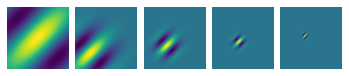

In [5]:
# @title Visualize a sample of gabors (optional)
# Replicating sup figure 2


fig, axs = plt.subplots(1,5)
fig.subplots_adjust(wspace=.1)


idx = [4,34,156,648,2590] # only done by eye - might not be precisely correct values

for i in range(len(axs)):
  axs[i].imshow(gabor_wavelet_pyramid[:,:,idx[i]]);
  axs[i].axis('off')

### Project training images into gabor space

**Either run cell 1 (to load the data), or 2 or 3 (to generate data a-fresh):**

In [ ]:
# @title 1. Load gabor-space training images from previous run

from google.colab import files

# download to local from https://github.com/da5nsy/ReplicatingKay2008/blob/master/datafiles/proj.npy
# there must be a way to do this directly but we don't know it (wget?)

files.upload()
proj = np.load('proj.npy')

In [ ]:
# @title 2. Project images into gabor space (vectorized version - takes roughly 40 minutes)
t = time.time()
image_lib = dat["stimuli"].reshape(dat["stimuli"].shape[0], -1)
gabor_lib = np.moveaxis(gabor_wavelet_pyramid, -1, 0)
gabor_lib = gabor_lib.reshape(gabor_lib.shape[0], -1)

num_images = image_lib.shape[0] # can be any number
num_gabors = gabor_lib.shape[0] # should be even number since gabors are pairs

image_lib = image_lib[:num_images, :]
gabor_lib = gabor_lib[:num_gabors, :]

gabor_lib_000_phase = gabor_lib[::2, :]
gabor_lib_180_phase = gabor_lib[1::2, :]
gabor_lib_000_phase_norm = np.sqrt(np.sum(gabor_lib_000_phase ** 2, axis=1)).reshape(1, -1)
gabor_lib_180_phase_norm = np.sqrt(np.sum(gabor_lib_180_phase ** 2, axis=1)).reshape(1, -1)

t1 = ( image_lib @ gabor_lib_000_phase.T ) / gabor_lib_000_phase_norm
t2 = ( image_lib @ gabor_lib_180_phase.T ) / gabor_lib_180_phase_norm

proj = np.sqrt((t1**2)+(t2**2))

elapsed = time.time() - t
print('Time elapsed:', elapsed)

In [ ]:
# @title 3. Project images into gabor space (original version - takes roughly 2 hours)

t = time.time()
out = display(progress(0, 100), display_id=True) #generate waitbar

proj = np.zeros((len(dat["stimuli"]),gabor_wavelet_pyramid.shape[2]//2))

for i in range(len(dat["stimuli"])): #training images 
  for j in range(0,gabor_wavelet_pyramid.shape[2],2):
    a = dat["stimuli"][i].reshape(-1)
    b = gabor_wavelet_pyramid[:,:,j].reshape(-1)
    c = gabor_wavelet_pyramid[:,:,j+1].reshape(-1)
    t1 = (a@b)/np.sqrt(b.T@b)
    t2 = (a@c)/np.sqrt(c.T@c)
    proj[i,(j+1)//2] = np.sqrt((t1**2)+(t2**2))
    # proj[i,(j+1)//2] = t1+t2 # the above means that we only ever get out positive weights, which doesn't feel right. Testing this version instead.

  out.update(progress(i, len(dat["stimuli"])-1)) # update waitbar

elapsed = time.time() - t
print('Time elapsed:', elapsed)


Run the following cell if you ran cell 2 or 3 above, to save the generated array (so that you can run cell 1 next time!)

In [ ]:
# @title Save proj file

np.save('proj.npy',proj)

Visualize projection data (optional)

In [ ]:
plt.hist(np.concatenate(proj),bins=100);

### Project testing images into gabor space

**Either run cell 1 (to load the data) or 2 (to generate data a-fresh).**

In [53]:
# @title 1. Load gabor-space test images from previous run

from google.colab import files

# download to local from https://github.com/da5nsy/ReplicatingKay2008/blob/master/datafiles/proj_test.npy
# there must be a way to do this directly but we don't know it (wget?)

files.upload()
proj_test = np.load('proj_test.npy')

Saving proj_test.npy to proj_test.npy


In [ ]:
# @title 2. Project test images into gabor space (vectorized version)

# Copied from vectorized version above

t = time.time()
image_lib = dat["stimuli_test"].reshape(dat["stimuli_test"].shape[0], -1)
gabor_lib = np.moveaxis(gabor_wavelet_pyramid, -1, 0)
gabor_lib = gabor_lib.reshape(gabor_lib.shape[0], -1)

num_images = image_lib.shape[0] # can be any number
num_gabors = gabor_lib.shape[0] # should be even number since gabors are pairs

image_lib = image_lib[:num_images, :]
gabor_lib = gabor_lib[:num_gabors, :]

gabor_lib_000_phase = gabor_lib[::2, :]
gabor_lib_180_phase = gabor_lib[1::2, :]
gabor_lib_000_phase_norm = np.sqrt(np.sum(gabor_lib_000_phase ** 2, axis=1)).reshape(1, -1)
gabor_lib_180_phase_norm = np.sqrt(np.sum(gabor_lib_180_phase ** 2, axis=1)).reshape(1, -1)

t1 = ( image_lib @ gabor_lib_000_phase.T ) / gabor_lib_000_phase_norm
t2 = ( image_lib @ gabor_lib_180_phase.T ) / gabor_lib_180_phase_norm

proj_test = np.sqrt((t1**2)+(t2**2))

elapsed = time.time() - t
print('Time elapsed:', elapsed)

Run the following cell if you ran cell 2 above, to save the generated array (so that you can run cell 1 next time!)

In [ ]:
# @title Save proj_test file

np.save('proj_test.npy',proj_test)

### Construct the model

In [12]:
## @title Load additional libraries

from sklearn.linear_model import LinearRegression

In [77]:
# Prepare data

X = proj
y = dat["responses"][:,0] # first voxel only!

print(X.shape)
print(y.shape)

(1750, 2729)
(1750,)


In [78]:
reg = LinearRegression().fit(X, y)

In [79]:
reg.score(X, y)

1.0

In [80]:
print(reg.coef_)
print(reg.coef_.shape)

[-0.07811678  0.04068248 -0.05914982 ...  0.          0.
  0.01348594]
(2729,)


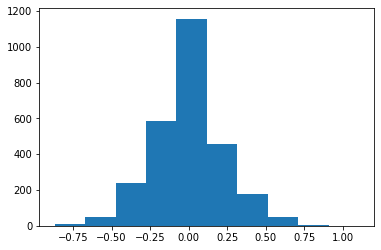

In [81]:
plt.hist(reg.coef_);

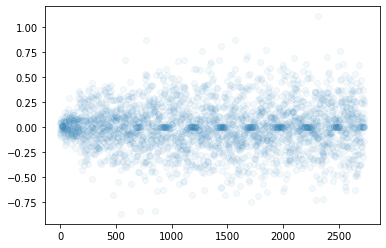

In [82]:
plt.scatter(range(len(reg.coef_)),reg.coef_,alpha = 0.05);

In [83]:
reg.intercept_

-0.3102335189870421

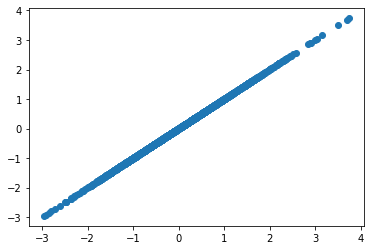

In [86]:
plt.scatter(reg.predict(X),y)

# Testing on unseen data

In [84]:
print(proj_test.shape)
print(dat["responses_test"].shape)

(120, 2729)
(120, 8428)


In [71]:
vx1test = reg.predict(proj_test)
#print(vx1test)
print(vx1test.shape)

(120,)


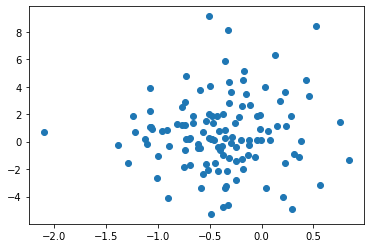

In [75]:
plt.scatter(dat["responses_test"][:,0],vx1test)

In [ ]:
# Multi-voxels

# X = proj
# for i in range(10):#range(dat["responses_test"].shape[1]-1):
#   y = dat["responses"][:,i]
#   reg = LinearRegression().fit(X, y)

#   print(reg.score(X, y))
#   #plt.scatter(dat["responses_test"][:,i],vx1test)